# Fraud Detection Model - Accredian Internship Task
This notebook develops a fraud detection model using the PaySim dataset.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [4]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=100000)
# print(df.head())  # First 5 rows
# print(df.info())  # Data types, non-null counts
# print(df.describe())  # Stats like mean, min, max
# print(df['isFraud'].value_counts(normalize=True))  # Fraud imbalance (~0.0013 or 0.13%)

In [5]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB
None


In [7]:
print(df.describe())

                step        amount  oldbalanceOrg  newbalanceOrig  \
count  100000.000000  1.000000e+05   1.000000e+05    1.000000e+05   
mean        8.499640  1.736022e+05   8.777575e+05    8.940619e+05   
std         1.825545  3.443003e+05   2.673284e+06    2.711318e+06   
min         1.000000  3.200000e-01   0.000000e+00    0.000000e+00   
25%         8.000000  9.963562e+03   0.000000e+00    0.000000e+00   
50%         9.000000  5.274552e+04   2.006150e+04    0.000000e+00   
75%        10.000000  2.117631e+05   1.901920e+05    2.148132e+05   
max        10.000000  1.000000e+07   3.379739e+07    3.400874e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    1.000000e+05    1.000000e+05  100000.000000        100000.0  
mean     8.805048e+05    1.184041e+06       0.001160             0.0  
std      2.402267e+06    2.802350e+06       0.034039             0.0  
min      0.000000e+00    0.000000e+00       0.000000             0.0  
25%      0.000000e+00  

In [8]:
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    0.99884
1    0.00116
Name: proportion, dtype: float64


In [9]:
print(df.duplicated().sum())

0


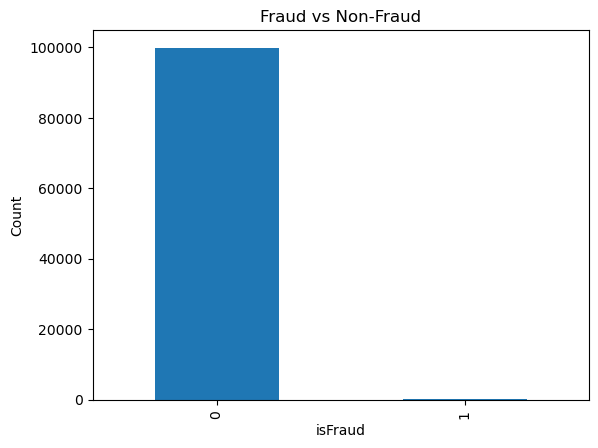

In [10]:
# Initial visualization
fraud_counts = df['isFraud'].value_counts()
fraud_counts.plot(kind='bar')
plt.title("Fraud vs Non-Fraud")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

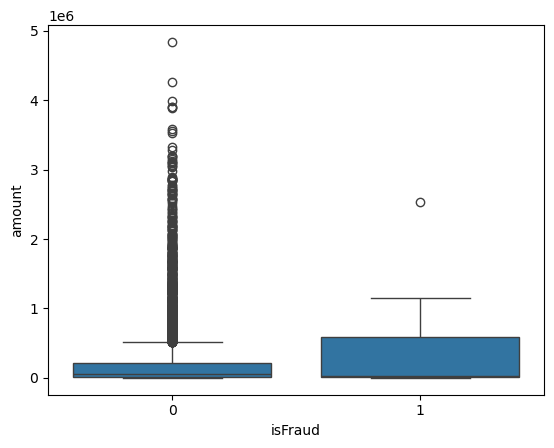

In [11]:
# Amount by fraud
sample_df = df.sample(10000, random_state=42) 
sns.boxplot(x='isFraud', y='amount', data=sample_df)
plt.show()


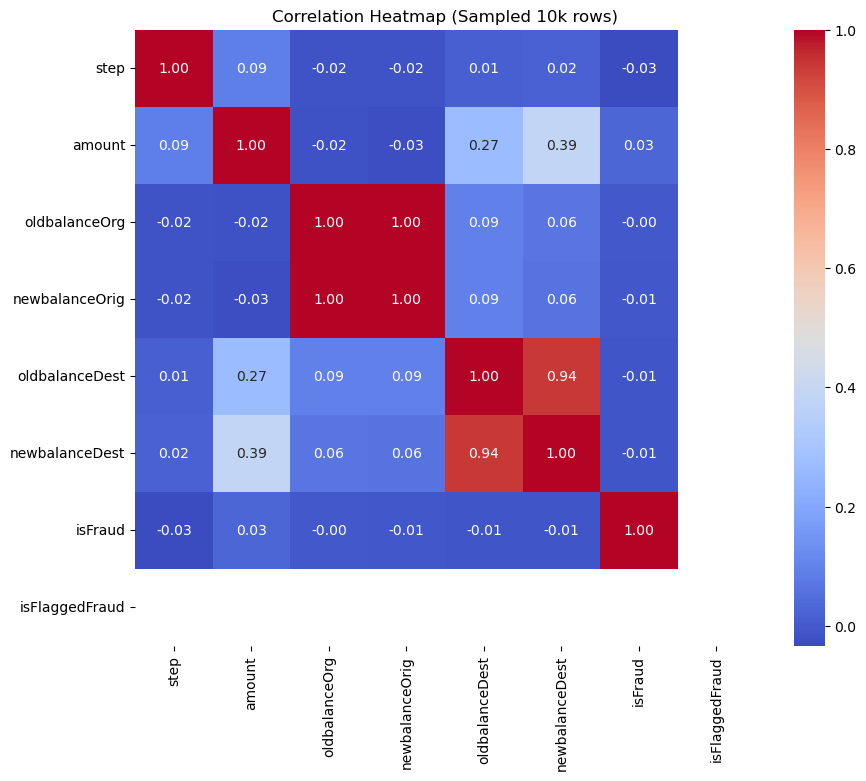

In [12]:
# heatmap
corr = sample_df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Sampled 10k rows)")
plt.show()

In [13]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [14]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

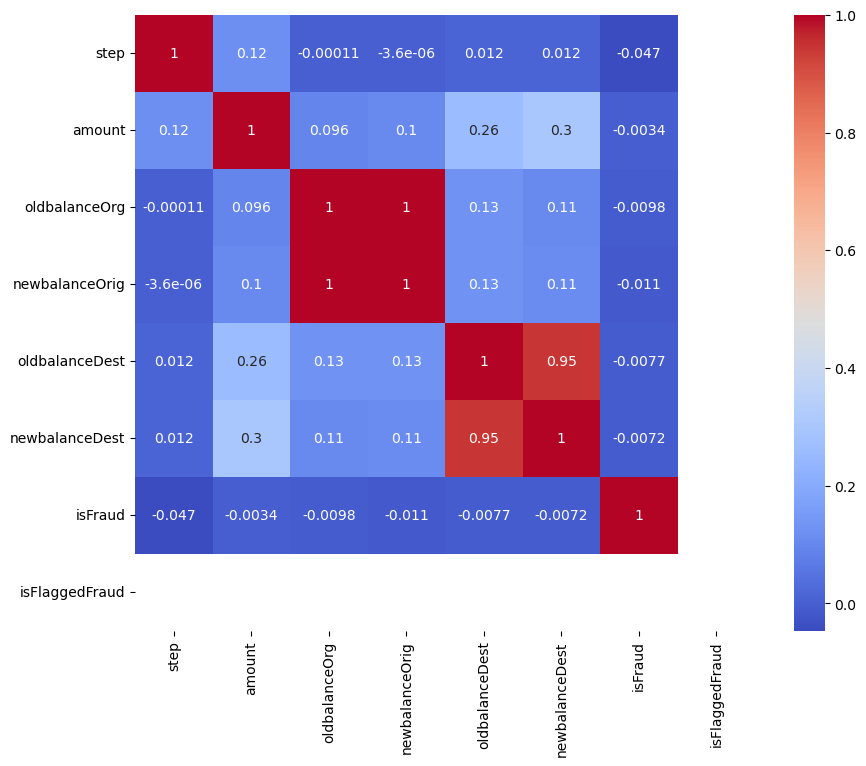

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [16]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [17]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [18]:
df.to_csv('cleaned_data.csv', index=False)

In [19]:
df_clean = pd.read_csv('cleaned_data.csv')

In [20]:
X = df_clean.drop(['isFraud', 'isFlaggedFraud'], axis=1)  
y = df_clean['isFraud']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(y_train_res.value_counts())

isFraud
0    74804
1    74804
Name: count, dtype: int64


In [23]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [24]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

C:\Users\deept\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [19:46:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
import joblib
joblib.dump(model, 'fraud_model.pkl')

['fraud_model.pkl']

In [26]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] 

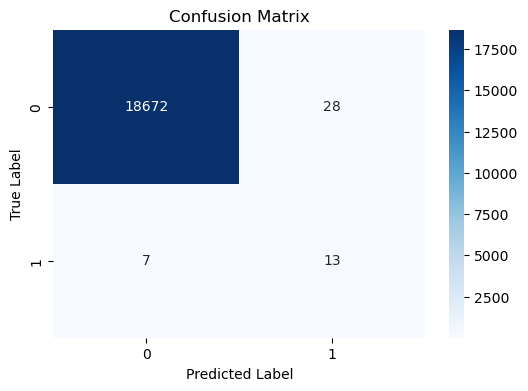

In [27]:
# Evaluation
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [28]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18700
           1       0.32      0.65      0.43        20

    accuracy                           1.00     18720
   macro avg       0.66      0.82      0.71     18720
weighted avg       1.00      1.00      1.00     18720



In [29]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9498


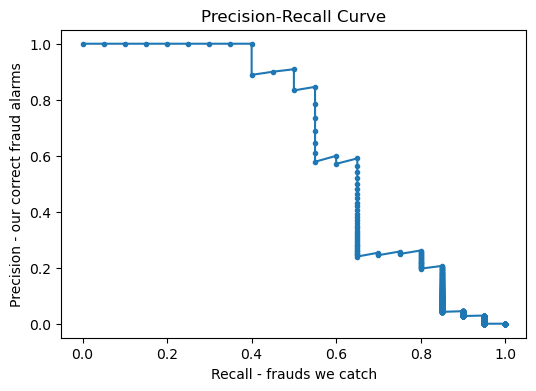

In [30]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall - frauds we catch')
plt.ylabel('Precision - our correct fraud alarms')
plt.show()

          feature  importance
3  newbalanceOrig    0.278966
0            step    0.239114
9   type_TRANSFER    0.235709
8    type_PAYMENT    0.145401
6   type_CASH_OUT    0.048006
2   oldbalanceOrg    0.025851
7      type_DEBIT    0.010758
5  newbalanceDest    0.005842
1          amount    0.005693
4  oldbalanceDest    0.004660


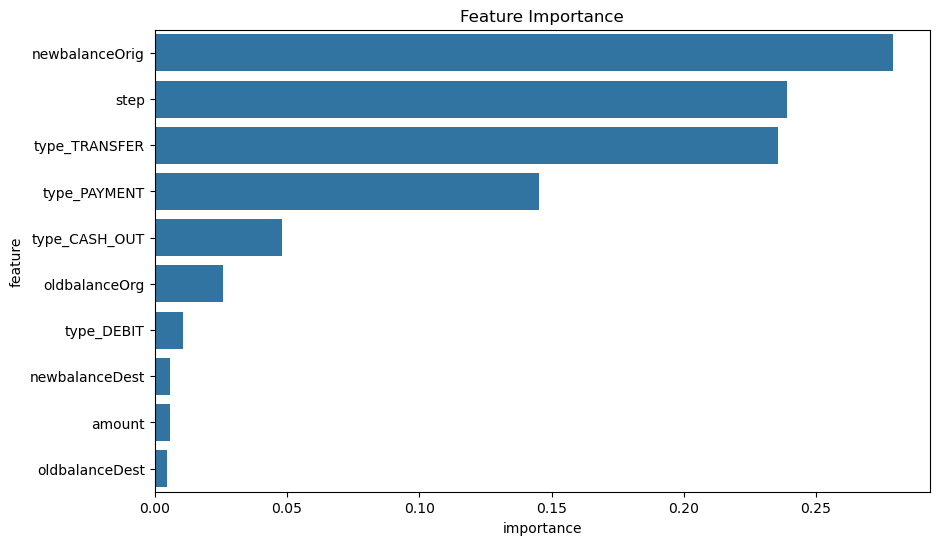

In [31]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()